In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import pickle
import numpy as np
import os
import random

import math as m
pi = m.pi

import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
n = 100
batch_size = 400
input_size = 1
range_scale = 2
train_size = 500000
valid_size = 50000

In [3]:
# Create or import data
if not os.path.isfile(os.path.join('/home/zhenisbek/FNN/absvalue/data', 'absvalue_train.pkl')): 
    x_train = np.random.uniform(-pi, pi, [train_size, 1])
    y_train = np.squeeze(np.absolute(x_train))
    with open(os.path.join('/home/zhenisbek/FNN/absvalue/data', 'absvalue_train.pkl'), 'wb') as my_file:
        pickle.dump(x_train, my_file)
        pickle.dump(y_train, my_file)
else:
    with open(os.path.join('/home/zhenisbek/FNN/absvalue/data', 'absvalue_train.pkl'), 'rb') as my_file:
        x_train = pickle.load(my_file)
        y_train = pickle.load(my_file)

if not os.path.isfile(os.path.join('/home/zhenisbek/FNN/absvalue/data', 'absvalue_valid.pkl')): 
    x_valid = np.random.uniform(-pi, pi, [valid_size, 1])
    y_valid = np.squeeze(np.absolute(x_valid))
    with open(os.path.join('/home/zhenisbek/FNN/absvalue/data', 'absvalue_valid.pkl'), 'wb') as my_file1:
        pickle.dump(x_valid, my_file1)
        pickle.dump(y_valid, my_file1)
else:
    with open(os.path.join('/home/zhenisbek/FNN/absvalue/data', 'absvalue_valid.pkl'), 'rb') as my_file1:
        x_valid = pickle.load(my_file1)
        y_valid = pickle.load(my_file1)


# Batching
def get_batch(i):
    n=i%batch_size
    x_batch=x_train[(n*batch_size):(batch_size*(n+1))]
    y_batch=y_train[(n*batch_size):(batch_size*(n+1))]
    return x_batch, y_batch

def get_batch_valid(i):
    n=i%batch_size
    x_batch=x_valid[(n*batch_size):(batch_size*(n+1))]
    y_batch=y_valid[(n*batch_size):(batch_size*(n+1))]
    return x_batch, y_batch


# Number of batches in train and valid splits
total_batch = int(x_train.shape[0]/batch_size)
valid_total_batch=int(x_valid.shape[0]/batch_size)

In [4]:
class Vanilla:
  '''Vanilla NN Model'''
  def __init__(self):
    # Placeholders and model parameters
    self.x = tf.placeholder(tf.float32, [None, input_size])
    self.y = tf.placeholder(tf.float32, [None])

    with tf.variable_scope('Vanilla'):
      self.w_1 = tf.get_variable("w_1", shape=[input_size, n])
      self.w_2 = tf.get_variable("w_2", shape=[n, 1])
      self.b_1 = tf.get_variable("b_1", shape=[n])
      self.b_2 = tf.get_variable("b_2", shape=[1])

    # One-hidden layer NN
    self.pre_hidden = tf.matmul(self.x, self.w_1) + self.b_1 
    self.hidden = tf.nn.sigmoid(self.pre_hidden)
    self.yhat = tf.squeeze(tf.matmul(self.hidden, self.w_2) + self.b_2, 1)
    
    # Cost function and optimizer
    self.Q = tf.nn.l2_loss(self.yhat - self.y)
    optimizer = tf.train.AdamOptimizer()
    self.train_op = optimizer.minimize(self.Q)

In [5]:
class GW:
  '''Gallant & White Model'''
  def __init__(self):
    # Placeholders and model parameters
    self.x = tf.placeholder(tf.float32, [None, input_size])
    self.y = tf.placeholder(tf.float32, [None])

    with tf.variable_scope('GW'):
      self.w_1 = tf.get_variable("w_1", shape=[input_size, n])
      self.w_2 = tf.get_variable("w_2", shape=[n, 1])
      self.b_1 = tf.get_variable("b_1", shape=[n])
      self.b_2 = tf.get_variable("b_2", shape=[1])

    # GW activation function
    def gw(u):
        return tf.cast(tf.greater_equal(u,-pi/2),tf.float32)*tf.cast(tf.less(u,pi/2),tf.float32)*0.5*(tf.cos(u+(3*pi/2))+1)+(1-tf.cast(tf.less(u,pi/2),tf.float32))  
    
    # One-hidden layer NN
    self.pre_hidden = tf.matmul(self.x, self.w_1) + self.b_1 
    self.hidden = gw(self.pre_hidden)
    self.yhat = tf.squeeze(tf.matmul(self.hidden, self.w_2) + self.b_2, 1)
    
    # Cost function and optimizer
    self.Q = tf.nn.l2_loss(self.yhat - self.y)
    optimizer = tf.train.AdamOptimizer()
    self.train_op = optimizer.minimize(self.Q)

In [6]:
vanilla_graph = tf.Graph()
with vanilla_graph.as_default():
    vanilla = Vanilla()
    vanilla_saver = tf.train.Saver()

gw_graph = tf.Graph()
with gw_graph.as_default():
    gw = GW()
    gw_saver = tf.train.Saver()

    
vanilla_hiddens, vanilla_yhats = np.empty([valid_size, n]), np.empty([valid_size])
gw_hiddens, gw_yhats = np.empty([valid_size, n]), np.empty([valid_size]) 

with tf.Session(graph=vanilla_graph) as vanilla_sess, tf.Session(graph=gw_graph) as gw_sess:
    # Restore variables from disk.
    vanilla_saver.restore(
        vanilla_sess, os.path.join('/home/zhenisbek/FNN/absvalue/saves', 'Vanilla.ckpt'))
    print('Vanilla Model restored.')
    gw_saver.restore(
        gw_sess, os.path.join('/home/zhenisbek/FNN/absvalue/saves', 'GW.ckpt'))
    print('Gallant & White Model restored.')
  
    for l in range(valid_total_batch):
        x_batch_valid, y_batch_valid = get_batch_valid(l)
        vanilla_hidden, vanilla_yhat = vanilla_sess.run(
          [vanilla.pre_hidden, vanilla.yhat], {vanilla.x: x_batch_valid, vanilla.y: y_batch_valid})
        vanilla_hiddens[l * batch_size : (l + 1) * batch_size, :] = vanilla_hidden
        vanilla_yhats[l * batch_size : (l + 1) * batch_size] = vanilla_yhat
    
    vanilla_w2, vanilla_b2 = vanilla_sess.run([vanilla.w_2, vanilla.b_2])
    
    for l in range(valid_total_batch):
        x_batch_valid, y_batch_valid = get_batch_valid(l)
        gw_hidden, gw_yhat = gw_sess.run(
          [gw.pre_hidden, gw.yhat], {gw.x: x_batch_valid, gw.y: y_batch_valid})
        gw_hiddens[l * batch_size : (l + 1) * batch_size, :] = gw_hidden
        gw_yhats[l * batch_size : (l + 1) * batch_size] = gw_yhat
        
    gw_w2, gw_b2 = gw_sess.run([gw.w_2, gw.b_2])

INFO:tensorflow:Restoring parameters from /home/zhenisbek/FNN/absvalue/saves/Vanilla.ckpt
Vanilla Model restored.
INFO:tensorflow:Restoring parameters from /home/zhenisbek/FNN/absvalue/saves/GW.ckpt
Gallant & White Model restored.


In [12]:
abs_vanilla_errors = np.abs(vanilla_yhats - y_valid)
abs_gw_errors = np.abs(gw_yhats - y_valid)
vanilla_01 = np.percentile(abs_vanilla_errors, 10)
gw_99 = np.percentile(abs_gw_errors, 90)

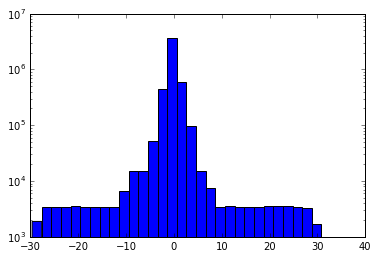

In [41]:
plt.hist(vanilla_hiddens.flatten(), bins=30, log=True)
plt.show()

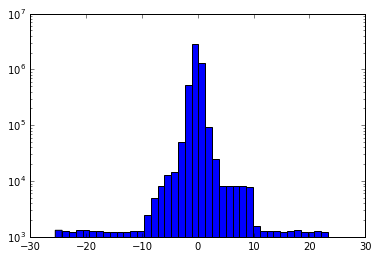

In [45]:
plt.hist(gw_hiddens.flatten(), bins=40, log=True)
#plt.savefig('pre_activ.pdf', format='pdf')
plt.show()

In [25]:
np.savetxt('pre-activ.csv', gw_hiddens.flatten(), delimiter=',')

In [37]:
len(gw_hiddens.flatten()[(gw_hiddens.flatten() < -pi/2) | (gw_hiddens.flatten() > pi/2)])/len(gw_hiddens.flatten())

0.0786188

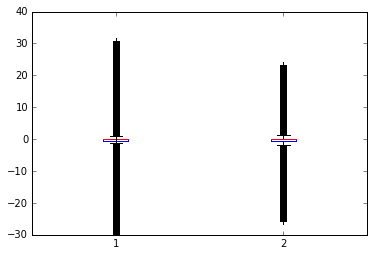

In [19]:
plt.boxplot([vanilla_hiddens.flatten(), gw_hiddens.flatten()])
plt.show()